# Gated Linear Units (GLUs)

In this example, we will explore the use of GLUs, and see how to use Keras-MML's version of GLUs (i.e., `GLUMML`).

:::{note}
For the last part of the notebook, we will be using some plotting utilities. You are free to skip them if you want; otherwise, these additional dependencies are required.
:::

In [1]:
%pip install matplotlib~=3.9.0 seaborn~=0.13.2


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## An Introduction to GLUs

In [_Language Modeling with Gated Convolutional Networks_](https://arxiv.org/pdf/1612.08083) by Dauphin et al., they introduced GLUs, attempting to replace recurrent connections commonly found in Recurrent Neural Networks (RNNs) with gated temporal connections. The idea behind GLUs is simple: we want the neural network to moderate how much information should flow through a given path, like a logical gate.

Suppose the information that 'wants' to flow through the network is represented by the vector $\mathbf{x}$. We moderate the amount of information that is retained by the network by multiplying $\mathbf{x}$ by a constant, say $\alpha$, that is bounded in the interval $[0, 1]$. In particular, when $\alpha = 0$, no information passes through the network, and when $\alpha = 1$ all the information stored in $\mathbf{x}$ passes through.

Now we want the network to also learn how much information to flow through the network, i.e. we want the network to also learn this proposed coefficient $\alpha$. To do so, we could use a `Dense` layer to learn $\alpha$, but we need to make sure that the values produced from this step stay in the interval $[0, 1]$. That's why Dauphin et al. proposes applying the sigmoid activation to this particular layer, in order to bound the coefficient within $[0, 1]$.

In the aforementioned paper, the hidden layers are calculated using
$$
h_l(\mathbf{x}) = (\mathbf{x}\mathbf{W} + \mathbf{b}) \otimes \sigma\left(\mathbf{x}\mathbf{V} + \mathbf{c}\right)
$$
where $\mathbf{x}$ is the input of the layer $h_l$, the matrices $\mathbf{W}, \mathbf{V}$ are weights to be learned by the network, $\mathbf{b}, \mathbf{c}$ are bias vectors that are to also be learned by the network, $\sigma$ is the sigmoid function, and $\otimes$ is the element-wise product between matrices.

Of course, there's no reason why we are restricting ourselves to the sigmoid activation function. In [_GLU Variants Improve Transformer_](https://arxiv.org/pdf/2002.05202) by Shazeer, they propose alternative activation functions, creating other GLU variants:
$$
\begin{align*}
    \mathrm{ReGLU}(\mathbf{x}, \mathbf{W}, \mathbf{V}, \mathbf{b}, \mathbf{c}) &= \max\left(0, \mathbf{x}\mathbf{W} + \mathbf{b}\right) \otimes (\mathbf{x}\mathbf{V} + \mathbf{c})\\
    \mathrm{GEGLU}(\mathbf{x}, \mathbf{W}, \mathbf{V}, \mathbf{b}, \mathbf{c}) &= \mathrm{GELU}\left(0, \mathbf{x}\mathbf{W} + \mathbf{b}\right) \otimes (\mathbf{x}\mathbf{V} + \mathbf{c})\\
    \mathrm{SwiGLU}(\mathbf{x}, \mathbf{W}, \mathbf{V}, \mathbf{b}, \mathbf{c}, \beta) &= \mathrm{Swish}_\beta\left(0, \mathbf{x}\mathbf{W} + \mathbf{b}\right) \otimes (\mathbf{x}\mathbf{V} + \mathbf{c})
\end{align*}
$$

:::{note}
The $\mathrm{Swish}$ activation function is also known as the $\mathrm{SiLU}$ (Sigmoid Linear Unit) activation function.
:::

## A Simple Example With GLUs

To demonstrate the use of GLUs, we make a simple dataset with the following rules.

1. Each feature vector is a 5-dimensional vector. For example, `[1, 0, 1, 0, 1]`.
2. If the first and third entries sum to at least 1, the output will be the input divided by 2. For example, `[1, 0, 1, 0, 1]` becomes `[0.5, 0, 0.5, 0., 0.5]`.
3. Otherwise the output will all be zeroes. For example `[0, 1, 0, 1, 0]` becomes `[0, 0, 0, 0, 0]`.

We create a dataset of 10000 entries.

In [2]:
import numpy as np

np.random.seed(42)  # For reproducibility

In [3]:
X = np.random.uniform(low=0, size=(10000, 5))

y = np.zeros_like(X)
condition = X[:, 0] + X[:, 2] >= 1
indices = np.where(condition)
y[indices] = X[indices] * 0.5

In [4]:
print(X[:5])
print(y[:5])

[[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]
 [0.15599452 0.05808361 0.86617615 0.60111501 0.70807258]
 [0.02058449 0.96990985 0.83244264 0.21233911 0.18182497]
 [0.18340451 0.30424224 0.52475643 0.43194502 0.29122914]
 [0.61185289 0.13949386 0.29214465 0.36636184 0.45606998]]
[[0.18727006 0.47535715 0.36599697 0.29932924 0.07800932]
 [0.07799726 0.02904181 0.43308807 0.30055751 0.35403629]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


We use a train-test split of 9:1.

In [5]:
train_data = X[:9000], y[:9000]
test_data = X[9000:], y[9000:]

The model that we will use is a simple SwiGLU model.

In [6]:
import keras

import keras_mml

2024-06-22 06:32:14.455524: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-22 06:32:14.455927: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-22 06:32:14.458432: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-22 06:32:14.488101: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-22 06:32:15.273016: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [7]:
model = keras.Sequential(
    layers=[
        keras.layers.Input(shape=(5,)),
        keras_mml.layers.GLUMML(32, activation="silu"),  # Silu is the same as Swish
        keras.layers.Dense(5)
    ], 
    name="SwiGLU-Model"
)
model.compile(
    loss="mse",
    optimizer="adam",
    metrics=["mae"]
)
model.summary()

Model: "SwiGLU-Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ glumml (GLUMML)                 │ (None, 32)             │        11,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,461 (44.77 KB)

 Trainable params: 11,461 (44.77 KB)

 Non-trainable params: 0 (0.00 B)

We define a callback to print the training output once every 10 epochs. This is to reduce clutter on the screen.

In [8]:
class print_training_results_Callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if int(epoch) % 10 == 0:
            print(
                f"Epoch: {epoch:>3}"
                + f" | loss: {logs['loss']:.5f}"
                + f" | mae: {logs['mae']:.5f}"
                + f" | val_loss: {logs['val_loss']:.5f}"
                + f" | val_mae: {logs['val_mae']:.5f}"
            )


Now we can train the model. We train it for 100 epochs using a batch size of 256.

In [9]:
NUM_EPOCHS = 100
BATCH_SIZE = 256

In [10]:
history = model.fit(
    train_data[0],
    train_data[1],
    validation_data=test_data,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
    callbacks=[print_training_results_Callback()]
)

Epoch:   0 | loss: 0.03272 | mae: 0.14553 | val_loss: 0.02589 | val_mae: 0.14263
Epoch:  10 | loss: 0.01283 | mae: 0.07979 | val_loss: 0.01252 | val_mae: 0.07964
Epoch:  20 | loss: 0.01246 | mae: 0.07686 | val_loss: 0.01172 | val_mae: 0.07601
Epoch:  30 | loss: 0.01217 | mae: 0.07523 | val_loss: 0.01185 | val_mae: 0.07684
Epoch:  40 | loss: 0.01214 | mae: 0.07533 | val_loss: 0.01137 | val_mae: 0.07134
Epoch:  50 | loss: 0.01196 | mae: 0.07427 | val_loss: 0.01160 | val_mae: 0.07332
Epoch:  60 | loss: 0.01193 | mae: 0.07397 | val_loss: 0.01122 | val_mae: 0.07167
Epoch:  70 | loss: 0.01186 | mae: 0.07391 | val_loss: 0.01136 | val_mae: 0.07253
Epoch:  80 | loss: 0.01175 | mae: 0.07329 | val_loss: 0.01126 | val_mae: 0.07070
Epoch:  90 | loss: 0.01182 | mae: 0.07360 | val_loss: 0.01122 | val_mae: 0.07205


In [11]:
test_mse, test_mae = model.evaluate(test_data[0], test_data[1])
print("Test MSE:", test_mse)
print("Test MAE:", test_mae)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0106 - mae: 0.0688 
Test MSE: 0.011189951561391354
Test MAE: 0.0705689936876297


Let's save the record of validation losses for later, so we can make a comparison between different GLU variants.

In [12]:
validation_losses = {}
validation_losses["SwiGLU"] = history.history["val_loss"]

### Other GLU Variants

Let's also try out the `GLUMML` layer on different GLU variants. We skip $\mathrm{SwiGLU}$ as we already did it above.

In [13]:
VARIANT_MAP = {
    "Bilinear": "linear",
    "GEGLU": "gelu",
    "ReGLU": "relu",
    "SeGLU": "selu"
}

In [14]:
def train_variant(variant_name):
    print(f" {variant_name} ".center(50, "="))
    activation_func = VARIANT_MAP[variant_name]
    
    model = keras.Sequential(
        layers=[
            keras.layers.Input(shape=(5,)),
            keras_mml.layers.GLUMML(32, activation=activation_func),
            keras.layers.Dense(5)
        ], 
        name=f"{variant_name}-Model"
    )
    model.compile(
        loss="mse",
        optimizer="adam",
        metrics=["mae"]
    )
    
    history = model.fit(
        train_data[0],
        train_data[1],
        validation_data=test_data,
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0,
        callbacks=[print_training_results_Callback()]
    )
    
    validation_losses[variant_name] = history.history["val_loss"]
    print()

In [15]:
for variant in VARIANT_MAP:
    train_variant(variant)

==================== Bilinear ====================
Epoch:   0 | loss: 0.03275 | mae: 0.14492 | val_loss: 0.02599 | val_mae: 0.14468
Epoch:  10 | loss: 0.01272 | mae: 0.07872 | val_loss: 0.01196 | val_mae: 0.07691
Epoch:  20 | loss: 0.01246 | mae: 0.07737 | val_loss: 0.01142 | val_mae: 0.07253
Epoch:  30 | loss: 0.01226 | mae: 0.07576 | val_loss: 0.01132 | val_mae: 0.07153
Epoch:  40 | loss: 0.01220 | mae: 0.07544 | val_loss: 0.01158 | val_mae: 0.07378
Epoch:  50 | loss: 0.01204 | mae: 0.07495 | val_loss: 0.01182 | val_mae: 0.07438
Epoch:  60 | loss: 0.01196 | mae: 0.07417 | val_loss: 0.01122 | val_mae: 0.07152
Epoch:  70 | loss: 0.01181 | mae: 0.07309 | val_loss: 0.01124 | val_mae: 0.07219
Epoch:  80 | loss: 0.01195 | mae: 0.07453 | val_loss: 0.01114 | val_mae: 0.07216
Epoch:  90 | loss: 0.01191 | mae: 0.07430 | val_loss: 0.01101 | val_mae: 0.06956

===================== GEGLU ======================
Epoch:   0 | loss: 0.03432 | mae: 0.14441 | val_loss: 0.02660 | val_mae: 0.14510
Epoch:

## Comparison Models

Let's also define two comparison models to assess against the GLU models.

The first will be a simple MLP that uses a $\mathrm{Sigmoid}$ activation in the middle layer.

In [16]:
model = keras.Sequential(
    layers=[
        keras.layers.Input(shape=(5,)),
        keras_mml.layers.DenseMML(32),
        keras_mml.layers.DenseMML(256, activation="sigmoid"),
        keras_mml.layers.DenseMML(32),
        keras.layers.Dense(5)
    ], 
    name="Dense-With-Sigmoid-Model"
)
model.compile(
    loss="mse",
    optimizer="adam",
    metrics=["mae"]
)
model.summary()

Model: "Dense-With-Sigmoid-Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_mml_10 (DenseMML)         │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_mml_11 (DenseMML)         │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_mml_12 (DenseMML)         │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,029 (66.52 KB)

 Trainable params: 17,029 (66.52 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    train_data[0],
    train_data[1],
    validation_data=test_data,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
    callbacks=[print_training_results_Callback()]
)
validation_losses["Dense-With-Sigmoid"] = history.history["val_loss"]

Epoch:   0 | loss: 0.03612 | mae: 0.14653 | val_loss: 0.02935 | val_mae: 0.15493
Epoch:  10 | loss: 0.02924 | mae: 0.15261 | val_loss: 0.02888 | val_mae: 0.15204
Epoch:  20 | loss: 0.02217 | mae: 0.12064 | val_loss: 0.02052 | val_mae: 0.11872
Epoch:  30 | loss: 0.01971 | mae: 0.10802 | val_loss: 0.01880 | val_mae: 0.10620
Epoch:  40 | loss: 0.01905 | mae: 0.10644 | val_loss: 0.01926 | val_mae: 0.11390
Epoch:  50 | loss: 0.01812 | mae: 0.10309 | val_loss: 0.01772 | val_mae: 0.10444
Epoch:  60 | loss: 0.01769 | mae: 0.10191 | val_loss: 0.01692 | val_mae: 0.09718
Epoch:  70 | loss: 0.01762 | mae: 0.10152 | val_loss: 0.01751 | val_mae: 0.10641
Epoch:  80 | loss: 0.01726 | mae: 0.10042 | val_loss: 0.01640 | val_mae: 0.09768
Epoch:  90 | loss: 0.01692 | mae: 0.09907 | val_loss: 0.01602 | val_mae: 0.09357


The second is similar to the first, but instead of $\mathrm{Sigmoid}$ we will use $\mathrm{ReLU}$.

In [18]:
model = keras.Sequential(
    layers=[
        keras.layers.Input(shape=(5,)),
        keras_mml.layers.DenseMML(32),
        keras_mml.layers.DenseMML(256, activation="relu"),
        keras_mml.layers.DenseMML(32),
        keras.layers.Dense(5)
    ], 
    name="Dense-With-ReLU-Model"
)
model.compile(
    loss="mse",
    optimizer="adam",
    metrics=["mae"]
)
model.summary()

Model: "Dense-With-ReLU-Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_mml_13 (DenseMML)         │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_mml_14 (DenseMML)         │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_mml_15 (DenseMML)         │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,029 (66.52 KB)

 Trainable params: 17,029 (66.52 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(
    train_data[0],
    train_data[1],
    validation_data=test_data,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
    callbacks=[print_training_results_Callback()]
)
validation_losses["Dense-With-ReLU"] = history.history["val_loss"]

Epoch:   0 | loss: 0.03467 | mae: 0.14679 | val_loss: 0.02846 | val_mae: 0.15224
Epoch:  10 | loss: 0.01219 | mae: 0.07456 | val_loss: 0.01133 | val_mae: 0.07054
Epoch:  20 | loss: 0.01134 | mae: 0.06835 | val_loss: 0.01056 | val_mae: 0.06630
Epoch:  30 | loss: 0.01114 | mae: 0.06820 | val_loss: 0.01107 | val_mae: 0.06637
Epoch:  40 | loss: 0.01109 | mae: 0.06740 | val_loss: 0.01116 | val_mae: 0.06718
Epoch:  50 | loss: 0.01097 | mae: 0.06672 | val_loss: 0.01053 | val_mae: 0.06516
Epoch:  60 | loss: 0.01083 | mae: 0.06636 | val_loss: 0.01058 | val_mae: 0.06566
Epoch:  70 | loss: 0.01098 | mae: 0.06647 | val_loss: 0.01018 | val_mae: 0.06248
Epoch:  80 | loss: 0.01075 | mae: 0.06513 | val_loss: 0.01049 | val_mae: 0.06429
Epoch:  90 | loss: 0.01108 | mae: 0.06650 | val_loss: 0.01052 | val_mae: 0.06678


## Plotting Losses

Let's plot the validation losses over time.

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

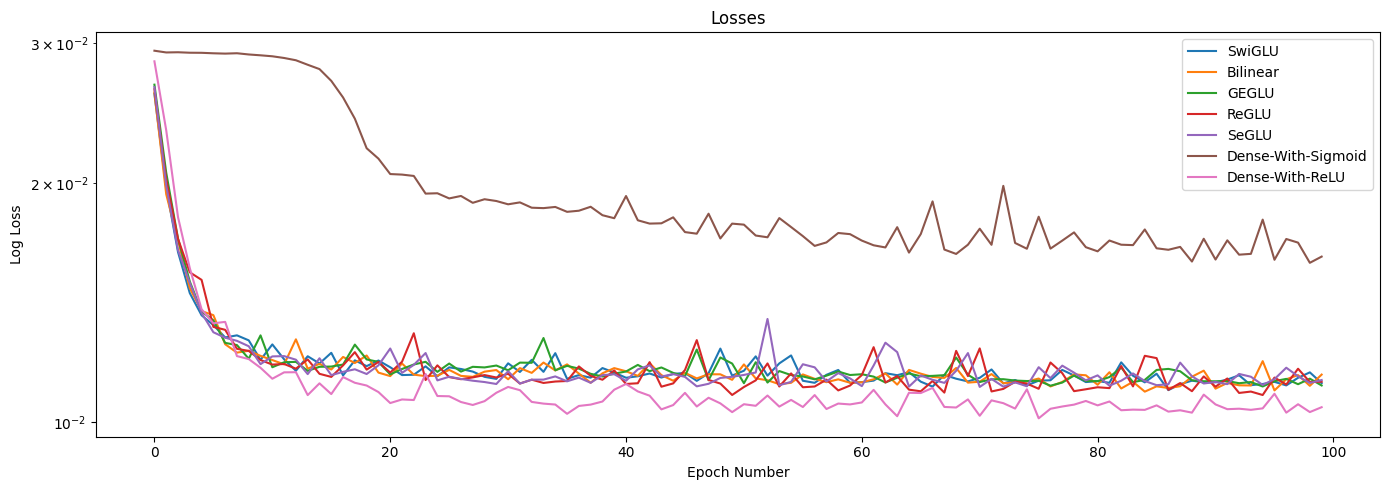

In [21]:
plt.figure(figsize=(14, 5), dpi=100)

for variant in validation_losses: 
    sns.lineplot(validation_losses[variant], label=variant)

plt.legend()
plt.yscale("log")
plt.ylabel("Log Loss")
plt.xlabel("Epoch Number")
plt.title("Losses")
plt.tight_layout()

We can't really see the losses after epoch 20, so let's zoom into that part specifically. Also, `Dense-With-Sigmoid` performs very poorly, so let's exclude that from our analysis below. 

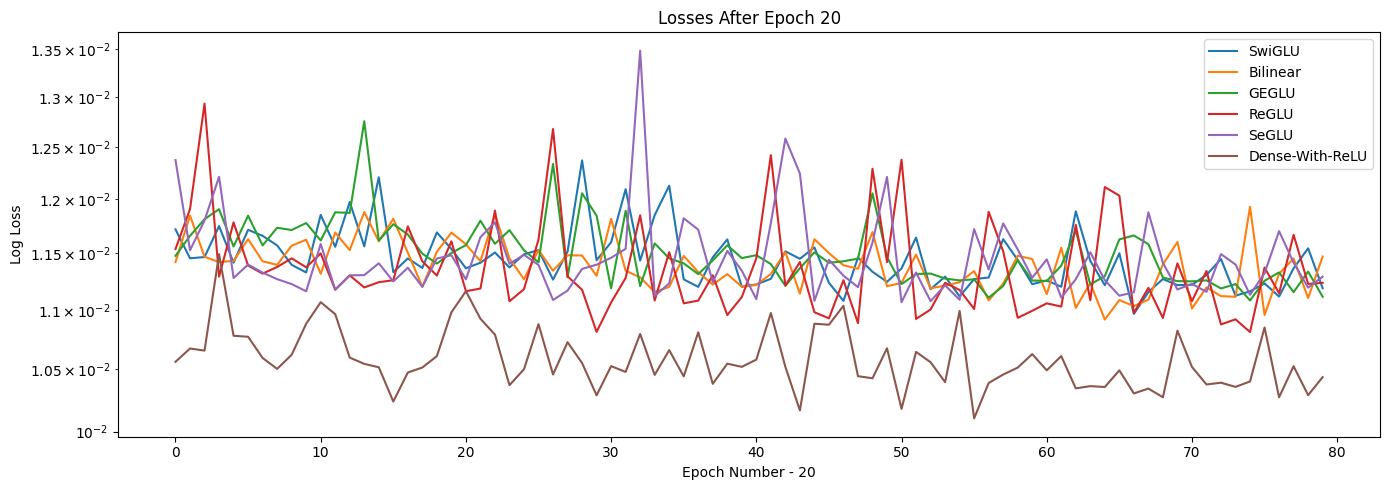

In [22]:
plt.figure(figsize=(14, 5), dpi=100)

for variant in validation_losses:
    if variant == "Dense-With-Sigmoid":
        continue
    sns.lineplot(validation_losses[variant][20:], label=variant)

plt.legend()
plt.yscale("log")
plt.ylabel("Log Loss")
plt.xlabel("Epoch Number - 20")
plt.title("Losses After Epoch 20")
plt.tight_layout()

From this, we can conclude that all the different models seem to stabilize pretty quickly. However, it is important to note that this is just a toy example, and that GLUs may have a different performance on real datasets. It is thus important to assess all different kinds of architectures before deciding on one.